### Partial Code for Final Project (skip-gram, AoIs, DKT, BKT)
Eli Pleaner and Julien Putz

#### Preparations

In [2]:
!pip install gensim
!pip install glob2
!pip install keras

In [1]:
import pandas as pd
import numpy as np
import json
import scipy
import jupyter
import matplotlib.pyplot as plt
import glob2 as glob
import re
import statistics
import gensim as gs
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, Lambda, multiply
from keras.models import Model as Model_rnn
from tensorflow.keras.optimizers import RMSprop, Adam  # changed from "from keras.optimizers import RMSprop, Adam"
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

import numpy as np
import pandas as pd
from pyBKT.models import Model as Model_bkt
import matplotlib.pyplot as plt

### Preprocessing

#### Importing datasets

In [2]:
# Import datasets
log_path = 'data/hand_eye_combined_logs'
out_plots_path = 'out/plots'

dfs = []

for f in glob.glob(log_path + "/*_Normalized.txt"):
  d = pd.read_csv(f, sep="\s+")
  id = re.findall(".*Subject_(\d+)_.*", f)[0]
  d["id"] = id
  dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
df

,TIME[s],LeftX,LeftY,RightX,RightY,GazeX,GazeY,GazeDuration,id
0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01
1,0.10000,NaN,NaN,NaN,NaN,374.00000,285.00000,"1,451.00000",01
2,0.20000,NaN,NaN,NaN,NaN,374.00000,285.00000,"1,451.00000",01
3,0.30000,NaN,NaN,NaN,NaN,208.00000,145.00000,369.00000,01
4,0.40000,NaN,NaN,NaN,NaN,208.00000,145.00000,369.00000,01
...,...,...,...,...,...,...,...,...,...
41671,354.40000,118.00000,482.00000,613.00000,958.00000,591.00000,976.00000,"1,717.00000",33
41672,354.50000,123.00000,488.00000,613.00000,962.00000,591.00000,976.00000,"1,717.00000",33
41673,354.60000,125.00000,493.00000,612.00000,967.00000,591.00000,976.00000,"1,717.00000",33
41674,354.70000,125.00000,495.00000,612.00000,971.00000,591.00000,976.00000,"1,717.00000",33


#### Gathering info about the dataset

In [3]:
# Gathering info about the dataset
time_stamps = df['TIME[s]'].tolist()
trial_length = []
t0 = 0
for t in time_stamps:
    t1 = t
    if t0 > t1:
        trial_length = trial_length + [t0]
    t0 = t1
trial_length = trial_length + [time_stamps[-1]]
print('Length of interactions: ', trial_length)

percent_missing = df[['LeftX', 'LeftY', 'RightX', 'RightY', 'GazeX', 'GazeY', 'GazeDuration']].isnull().sum() * 100 / len(df)
print('Percent of NaN in dataset:')
print(percent_missing)
print('Total percent of NaN: ', percent_missing.sum()/len(percent_missing))

Length of interactions:  [198.8, 263.8, 255.8, 210.8, 306.8, 340.8, 255.8, 328.8, 484.8, 563.8, 202.8, 195.8, 202.8, 354.8]
Percent of NaN in dataset:
LeftX          12.24446
LeftY          12.24446
RightX         11.39745
RightY         11.39745
GazeX          16.38113
GazeY          16.38113
GazeDuration    0.03359
dtype: float64
Total percent of NaN:  11.439951736525304


#### Defining "being in green"

In [4]:
# Create column with green/not green
def Green_conditions(leftY, rightY):
    if (abs(leftY/rightY-0.5) < 0.1):
        return 'Green'
    elif (abs(leftY/rightY-0.5) >= 0.1):
        return 'NotGreen'
    else:
        return 'nan'

df['InGreen'] = df.apply(lambda x: Green_conditions(x['LeftY'], x['RightY']),axis=1)

#### Defining student-specifc dynamic ROIs (as in Abdu, Tancredi, Abrahamson & Balasubramaniam (under review))

In [5]:
# Create student-specific lateral boundaries

# retrieve student ids
ids = df['id'].tolist()
ids = list(dict.fromkeys(ids))

# Create student-specific column boundaries for ROIs
for i in ids:
    stud = ids[0]
    lx = df.loc[df['id']==i,'LeftX'].tolist()
    lx = [x for x in lx if np.isnan(x) == False]

    ly = df.loc[df['id']==i,'LeftY'].tolist()
    ly = [x for x in ly if np.isnan(x) == False]

    rx = df.loc[df['id']==i,'RightX'].tolist()
    rx = [x for x in rx if np.isnan(x) == False]

    ry = df.loc[df['id']==i,'RightY'].tolist()
    ry = [x for x in ry if np.isnan(x) == False]

    rang_var = statistics.median(lx+rx)/8
    l_border = statistics.median(lx)-rang_var
    r_border = statistics.median(rx)+rang_var

    df.loc[df['id']==i,'LeftBorder'] = l_border
    df.loc[df['id']==i,'RightBorder'] = r_border

In [6]:
# Define ROI for each gaze position
def ROIconditions(leftB, rightB, leftY, rightY, gazeX, gazeY, roi):
    
    rightY = 1.1*rightY # enlarge topbar of right ROIs
    leftY = 1.1*leftY # enlarge topbar of left ROIs
    
    # if the gaze is in the left column
    if (leftB <= gazeX <= (leftB+rightB)/3):
        if (gazeY >= leftY): # if gaze is above left finger
            roi='L0'
        elif (leftY > gazeY >= 2*leftY/3): # if gaze is just below left finger
            roi='L1'
        elif (2*leftY/3 > gazeY >= leftY/3): # if gaze is between left finger and bottom
            roi='L2'
        elif (leftY/3 > gazeY >= 0): # if gaze is close to bottom
            roi='L3'
    
    # if the gaze is in the righ column
    elif (2*(leftB+rightB)/3 <= gazeX <= rightB):
        if (gazeY >= rightY): # if gaze is above right finger
            roi='R0'
        elif (rightY > gazeY >= 2*rightY/3): # if gaze is just below right finger
            roi='R1'
        elif (2*rightY/3 > gazeY >= rightY/3): # if gaze is between right finger and bottom
            roi='R2'
        elif (rightY/3 > gazeY >= 0): # if gaze is close to bottom
            roi='R3'
    
    # if the gaze is in the middle column
    elif ((leftB+rightB)/3 < gazeX < 2*(leftB+rightB)/3):
        if (gazeY >= max(leftY,rightY)): # if gaze is above highest finger
            roi='M0'
        elif (max(leftY,rightY) > gazeY >= 2*max(leftY,rightY)/3): # if gaze is just below highest finger
            roi='M1'
        elif (2*max(leftY,rightY)/3 > gazeY >= max(leftY,rightY)/3): # if gaze is between highest finger and bottom
            roi='M2'
        elif (max(leftY,rightY)/3 > gazeY >= 0): # if gaze is close to bottom
            roi='M3'
    return roi

# Add a column to df with ROIs 
df['ROI'] = df.apply(lambda x: ROIconditions(x['LeftBorder'], x['RightBorder'], x['LeftY'], x['RightY'], x['GazeX'], x['GazeY'], 'nan'), axis=1)

#### Create strings with rounded hand and gaze positions 

In [7]:
# Round Gaze/Hand positions to nearest 10
df[['GazeX','GazeY']] = df[['GazeX','GazeY']].apply(lambda x: round(x/50)*50)
df[['LeftY','RightY']] = df[['LeftY','RightY']].apply(lambda x: round(x/50)*50)

# Create column with Gaze positions as strings
df['Gaze'] = df['GazeX'].astype(str)+' '+df['GazeY'].astype(str)+' '+df['LeftY'].astype(str)+' '+df['RightY'].astype(str)
Gaze_df = df[['Gaze','id']]
Gaze_df = Gaze_df.groupby('id')['Gaze'].apply(list).reset_index()
Gaze = Gaze_df['Gaze'].tolist()

### Creating a skip-gram model

In [8]:
# Train skip-gram model (sg=1 is for skip-gram)
sg_model = gs.models.Word2Vec(Gaze, vector_size=120, window=6, min_count=1, sg=1, epochs=15)
positions = list(sg_model.wv.key_to_index.keys())
sg_model.save("word2vec.model")

# Inspect the skip-gram model
print(f'Total number gaze datapoints: {sg_model.corpus_total_words}')
print(f'Number of gaze positions: {len(positions)}')
print(f'Sample gaze positions: {list(sg_model.wv.key_to_index.keys())[20:30]}')
sample_pos = list(sg_model.wv[positions[0]])
print(f'Sample embedding: {sample_pos}')

Total number gaze datapoints: 41676
Number of gaze positions: 9064
Sample gaze positions: ['600.0 450.0 250.0 450.0', '600.0 250.0 50.0 100.0', '600.0 350.0 150.0 300.0', '600.0 600.0 300.0 600.0', '200.0 200.0 nan nan', 'nan nan 150.0 250.0', '600.0 850.0 400.0 850.0', 'nan nan 250.0 500.0', '600.0 150.0 nan nan', '600.0 250.0 nan nan']
Sample embedding: [0.6683829, 0.057094894, -0.061972354, 1.3865058, -0.7321685, -0.319581, 0.35084766, 0.8190067, -0.20311047, 0.16859771, 0.17694166, -0.13835569, -0.2731135, 1.0355468, 0.39917853, -0.074363396, 0.30582905, -0.5110075, 0.055152826, -0.73699784, 0.85314375, -0.19397207, 0.82176393, 0.12584303, 0.5185744, 0.018878423, -0.55176324, 0.7776467, -0.6293922, -1.1332241, -0.060555797, -0.49672082, 0.55773103, 0.11299453, 0.21841154, -0.5779543, -0.15792473, -0.72322536, -0.42233196, -0.8280221, -0.7009149, -0.074424215, 0.05654612, -0.53535986, -0.52408415, -0.11453658, -1.092209, 1.2443414, 0.37535372, 0.9574535, -0.59869426, -0.1577591, -0.

### Using t-SNE to reduce the dimensionality of the skip-gram embedding

In [9]:
# Extract the vector representations from the model
vector_reps = sg_model.wv[positions]

# Show sample vector representations
for n in range(5):
    vec = list(vector_reps[n])[:4]
    vec.append('...')
    print(vec)

[0.6683829, 0.057094894, -0.061972354, 1.3865058, '...']
[0.46320158, -1.0743228, 0.44085085, 0.25866792, '...']
[0.6567974, 0.40194502, 0.6071667, 0.29693663, '...']
[-0.101785764, 0.64515394, 0.60734326, 0.8132143, '...']
[0.36389068, 0.31345314, -0.17073782, 0.934133, '...']


In [10]:
# Reduce the dimensionality to 2 using t-SNE
model_tsne=TSNE(n_components=2, perplexity=40, method='barnes_hut').fit_transform(vector_reps)

#### Visualizing the skip-gram, with labelled ROIs

In [11]:
# Obtain gaze positions with corresponding ROI
positions = list(sg_model.wv.key_to_index.keys())

# Extract the vector representations from the model
vector_reps = sg_model.wv[positions]

# Create list of ROIs corresponding to gaze positions
ROIss = []
for i, label in enumerate(positions):
    next_ROI = df.loc[df['Gaze'] == label, 'ROI'].iloc[0]
    ROIss.append(next_ROI)

# Creating a data frame with columns x, y, ROIs
df_plot_roi = pd.DataFrame(model_tsne[:,:2],columns=["x","y"])
df_plot_roi['ROIs'] = ROIss

#df_plot.to_csv('d3-scatterplot/df_test.tsv', sep='\t', index=False)
#df_plot.to_csv('d3-scatterplot/df_test.csv', sep='\t', index=False)

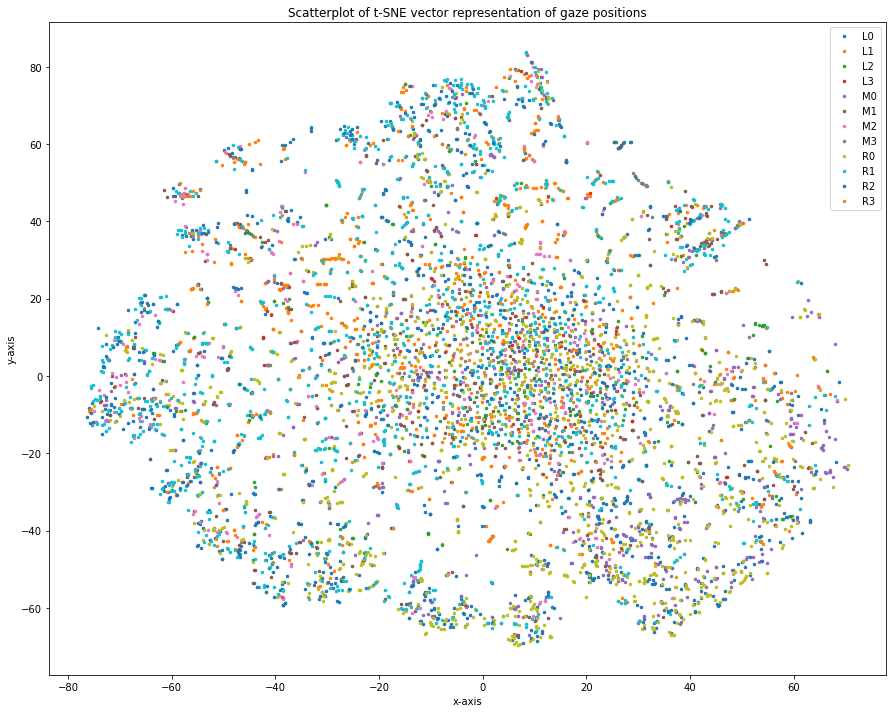

In [12]:
# Create scatterplot with ROI annotations
df_plot_roi = df_plot_roi.loc[df_plot_roi['ROIs']!='nan']
groups_roi = df_plot_roi.groupby('ROIs')
plt.figure(figsize=(15,12)) 
for name, group in groups_roi:
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=5, label=name)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Scatterplot of t-SNE vector representation of gaze positions") #title 
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig('multimodal_scatterplot_ROIs_perplexity40_vectorsize120_window6_rounded50.png')
plt.show()

#### Visualizing the skip-gram, with label "in green"

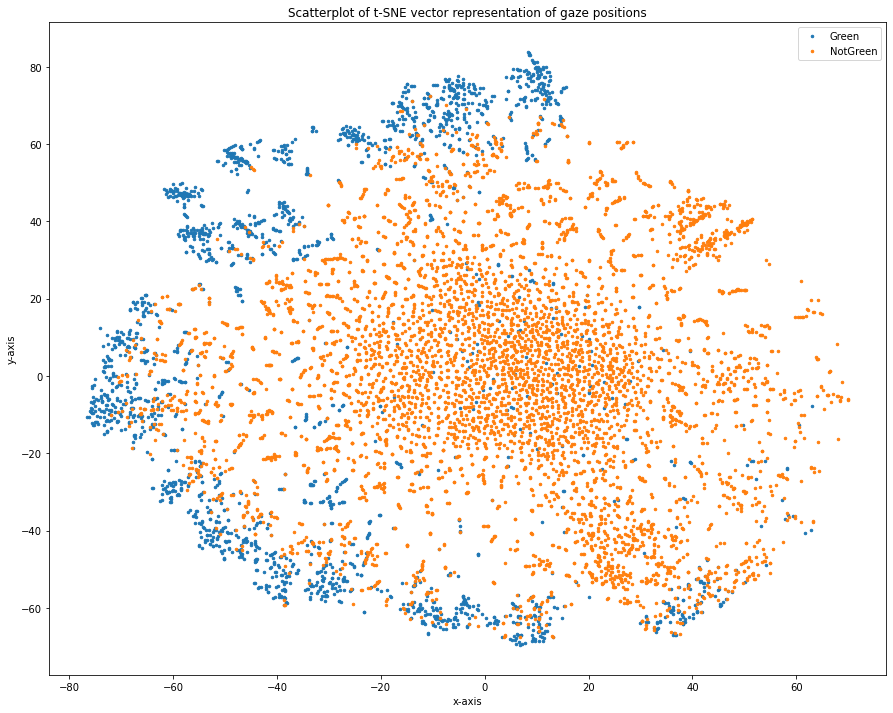

In [13]:
# Create list of InGreen corresponding to gaze positions
InGreens = []
for i, label in enumerate(positions):
    next_InGreen = df.loc[df['Gaze'] == label, 'InGreen'].iloc[0]
    InGreens.append(next_InGreen)

# Creating a data frame with columns x, y, ROIs
df_plot_gr = pd.DataFrame(model_tsne[:,:2],columns=["x","y"])
df_plot_gr['InGreen'] = InGreens

# Create scatterplot with ROI annotations
df_plot_gr = df_plot_gr.loc[df_plot_gr['InGreen']!='nan']
groups_gr = df_plot_gr.groupby('InGreen')
plt.figure(figsize=(15,12)) 
for name, group in groups_gr:
    plt.plot(group.x, group.y, marker='.', linestyle='', markersize=5, label=name)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Scatterplot of t-SNE vector representation of gaze positions") #title 
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.savefig('multimodal_scatterplot_InGreen2_perplexity40_vectorsize120_window6_rounded50.png')
plt.show()

### RNNs on preprocessed data

#### Prepare dataframe

In [14]:
# Removing rows where ROI or InGreen have null values
dff = df.loc[df['InGreen']!='nan']
dff = dff.loc[df['ROI']!='nan']
print('Nr of rows in complete df:', len(df))
print('Nr of rows in reduced df:', len(dff))

# Find shortest sequence of interactions
nr_interactions = []
for i in ids:
    nr_interactions = nr_interactions+[len(dff.loc[dff['id']==i])]
shortest_seq = min(nr_interactions)
print('The shortest interaction sequence is', shortest_seq, 'long.')

# Shorten interaction sequences to equal length
dff = dff.groupby('id').head(shortest_seq)

time_steps = []
for s in range(shortest_seq):
    if len(str(s))==1:
        time_steps = time_steps + ['s00'+str(s)]
    if len(str(s))==2:
        time_steps = time_steps + ['s0'+str(s)]
    if len(str(s))==3:
        time_steps = time_steps + ['s'+str(s)]

# Introduce new time steps
for i in ids:
    dff.loc[dff['id'] == i, 'time'] = time_steps

dff

Nr of rows in complete df: 41676
Nr of rows in reduced df: 23379
The shortest interaction sequence is 614 long.


,TIME[s],LeftX,LeftY,RightX,RightY,GazeX,GazeY,GazeDuration,id,InGreen,LeftBorder,RightBorder,ROI,Gaze,time
101,10.10000,116.00000,50.00000,514.00000,100.00000,600.00000,550.00000,495.00000,01,NotGreen,126.25000,586.75000,R0,600.0 550.0 50.0 100.0,s000
103,10.30000,107.00000,50.00000,512.00000,100.00000,150.00000,550.00000,355.00000,01,NotGreen,126.25000,586.75000,L0,150.0 550.0 50.0 100.0,s001
104,10.40000,108.00000,50.00000,511.00000,100.00000,150.00000,550.00000,355.00000,01,NotGreen,126.25000,586.75000,L0,150.0 550.0 50.0 100.0,s002
105,10.50000,114.00000,100.00000,510.00000,100.00000,150.00000,550.00000,355.00000,01,NotGreen,126.25000,586.75000,L0,150.0 550.0 100.0 100.0,s003
106,10.60000,124.00000,150.00000,507.00000,150.00000,150.00000,550.00000,355.00000,01,NotGreen,126.25000,586.75000,L0,150.0 550.0 150.0 150.0,s004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38894,76.70000,129.00000,350.00000,531.00000,600.00000,300.00000,700.00000,683.00000,33,Green,47.75000,634.25000,M0,300.0 700.0 350.0 600.0,s609
38895,76.80000,128.00000,350.00000,531.00000,600.00000,300.00000,700.00000,683.00000,33,Green,47.75000,634.25000,M0,300.0 700.0 350.0 600.0,s610
38896,76.90000,128.00000,350.00000,532.00000,600.00000,300.00000,700.00000,683.00000,33,Green,47.75000,634.25000,M0,300.0 700.0 350.0 600.0,s611
38897,77.00000,128.00000,350.00000,535.00000,600.00000,300.00000,700.00000,683.00000,33,Green,47.75000,634.25000,M0,300.0 700.0 350.0 600.0,s612


#### Create ROI_df dataframe as imput for DKT

In [15]:
# Create new dataframe with appropriate format for RNNs
ROI_df = dff.pivot(index='id', columns='time', values='ROI').reset_index()
ROI_df = ROI_df.rename_axis(None, axis=1)

# Replace ROI names with numbers
dict_ROIs = {'L0':1,'L1':2,'L2':3,'L3':4,'M0':5,'M1':6,'M2':7,'M3':8,'R0':9,'R1':10,'R2':11,'R3':12}
ROI_df[time_steps]=ROI_df[time_steps].replace(dict_ROIs)
ROI_df

,id,s000,s001,s002,s003,s004,s005,s006,s007,s008,...,s604,s605,s606,s607,s608,s609,s610,s611,s612,s613
0,01,9,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12
1,02,5,5,1,1,1,1,9,9,10,...,2,2,2,2,2,2,2,2,2,2
2,03,5,5,1,1,2,2,9,9,9,...,9,2,2,9,9,9,9,9,9,9
3,04,5,5,5,5,5,5,5,5,1,...,11,11,10,9,9,9,9,9,9,9
4,06,9,9,9,9,9,9,9,9,9,...,10,10,10,10,10,10,10,10,10,10
5,07,5,5,5,5,5,5,5,5,5,...,1,1,1,1,1,1,1,1,1,1
6,08,5,5,5,5,1,1,9,9,9,...,5,1,1,1,2,2,2,2,9,9
7,10,5,5,6,1,1,1,1,10,10,...,1,1,1,1,11,11,2,2,2,2
8,11,9,1,1,1,1,9,9,9,5,...,10,10,1,1,1,6,6,6,1,1
9,12,2,9,1,1,1,5,5,5,5,...,9,9,9,9,9,9,9,9,9,9


#### Create green_df dataframe as input for DKT

In [16]:
# Create new dataframe with appropriate format for RNNs
green_df = dff.pivot(index='id', columns='time', values='InGreen').reset_index()
green_df = green_df.rename_axis(None, axis=1)

# Replace ROI names with numbers
dict_green = {'Green':1,'NotGreen':0}
green_df[time_steps]=green_df[time_steps].replace(dict_green)
green_df

#ROI_keys = list(dict_ROIs.keys())
#ROI_values = list(dict_ROIs.values())

,id,s000,s001,s002,s003,s004,s005,s006,s007,s008,...,s604,s605,s606,s607,s608,s609,s610,s611,s612,s613
0,01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
1,02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,06,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,07,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6,08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,10,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
8,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,12,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


#### DKT Code

In [17]:
# Functions for preparing RNN input
def preprocess(skill_df, response_df, skill_num):
    skill_matrix = skill_df.iloc[:, 1:].values
    response_array = response_df.iloc[:, 1:].values
    skill_array = one_hot(skill_matrix, skill_num)
    skill_response_array = dkt_one_hot(skill_matrix, response_array, skill_num)
    return skill_array, response_array, skill_response_array


def dkt_one_hot(skill_matrix, response_matrix, vocab_size):
    seq_len = skill_matrix.shape[1]
    skill_response_array = np.zeros((skill_matrix.shape[0], seq_len, 2 * vocab_size))
    for i in range(skill_matrix.shape[0]):
        skill_response_array[i, np.arange(seq_len), 2 * skill_matrix[i] + response_matrix[i]] = 1.
    return skill_response_array

def one_hot(skill_matrix, vocab_size):
    '''
    params:
        skill_matrix: 2-D matrix (student, skills)
        vocal_size: size of the vocabulary
    returns:
        a ndarray with a shape like (student, sequence_len, vocab_size)
    '''
    seq_len = skill_matrix.shape[1]
    result = np.zeros((skill_matrix.shape[0], seq_len, vocab_size))
    for i in range(skill_matrix.shape[0]):
        result[i, np.arange(seq_len), skill_matrix[i]] = 1.
    return result

# performance prediction model (DKT)
def build_dkt_model(input_shape, lstm_dim=32, dropout=0.0):
    input_skills = Input(shape=input_shape, name='input_skills')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input_skills)
    dense = TimeDistributed(Dense(int(input_shape[-1]/2), activation='sigmoid'), name='probability_for_each')(lstm)
    
    skill_next = Input(shape=(input_shape[0], int(input_shape[1]/2)), name='next_skill_tested')
    merged = multiply([dense, skill_next], name='multiply')
    reduced = Lambda(reduce_dim, output_shape=(input_shape[0], 1), name='reduce_dim')(merged)
    
    dkt_model = Model_rnn(inputs=[input_skills, skill_next], outputs=[reduced])
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    dkt_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    dkt_model.summary()
    return dkt_model

# sequence prediction model (behavior)
def build_skill2skill_model(input_shape, lstm_dim=32, dropout=0.0):
    input = Input(shape=input_shape, name='input_skills')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input)
    output = TimeDistributed(Dense(input_shape[-1], activation='softmax'), name='probability')(lstm)
    dkt_model = Model_rnn(inputs=[input], outputs=[output])
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    dkt_modelmodel.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    dkt_modelmodel.summary()
    return dkt_model

def reduce_dim(x):
    x = K.max(x, axis=-1, keepdims=True)
    return x

# performance prediction model (DKT)
def build_dkt_model(input_shape, lstm_dim=32, dropout=0.0):
    input_skills = Input(shape=input_shape, name='input_skills')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input_skills)
    dense = TimeDistributed(Dense(int(input_shape[-1]/2), activation='sigmoid'), name='probability_for_each')(lstm)
    
    skill_next = Input(shape=(input_shape[0], int(input_shape[1]/2)), name='next_skill_tested')
    merged = multiply([dense, skill_next], name='multiply')
    reduced = Lambda(reduce_dim, output_shape=(input_shape[0], 1), name='reduce_dim')(merged)
    
    dkt_model = Model_rnn(inputs=[input_skills, skill_next], outputs=[reduced])
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    dkt_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy','mse'])
    dkt_model.summary()
    return dkt_model

#### Splitting the dataset in training and test data

In [20]:
# 70% of data used as training data
test_prop = 0.65

# Split user_ids/student_ids into 70% training and 30% test data
idx_split = np.array(ROI_df.id.unique())
np.random.seed(42)
np.random.shuffle(idx_split)
train_students = idx_split[:int(test_prop * len(idx_split))]
test_students = idx_split[int(test_prop * len(idx_split)):]

# Split green_df
train_green_df = green_df.loc[green_df['id'].isin(train_students)].reset_index(drop = True)
test_green_df = green_df.loc[green_df['id'].isin(test_students)].reset_index(drop = True)

# Split ROI_df
train_ROI_df = ROI_df.loc[ROI_df['id'].isin(train_students)].reset_index(drop = True)
test_ROI_df = ROI_df.loc[ROI_df['id'].isin(test_students)].reset_index(drop = True)

# Checking that the ratio of training data to test data is adequate
print('Training data is %5.3f' % (train_ROI_df.shape[0]/ROI_df.shape[0]),'% of total data')
print('Testing data is %5.3f' % (test_ROI_df.shape[0]/ROI_df.shape[0]),'% of total data')

Training data is 0.643 % of total data
Testing data is 0.357 % of total data


#### Training and evaluating an RNN/DKT model

In [21]:
# Create RNN input arrays from training and testing data
ROI_num = len(dict_ROIs) + 1
skill_num = ROI_num
train_skill_array, train_response_array, train_skill_response_array = preprocess(train_ROI_df, train_green_df, ROI_num)
test_skill_array, test_response_array, test_skill_response_array = preprocess(test_ROI_df, test_green_df, ROI_num)

# Initialize and fit DKT model
dkt_model = build_dkt_model((613, 2 * skill_num), lstm_dim=20, dropout=0.2)
dkt_model.fit([train_skill_response_array[:, 0:-1], train_skill_array[:, 1:]],
              train_response_array[:, 1:, np.newaxis],
              epochs=100,
              batch_size=32, 
              shuffle=True,
              validation_split=0.2)

# Evaulate model prediction accuracy on test data
result_dkt = dkt_model.evaluate([test_skill_response_array[:, 0:-1], test_skill_array[:, 1:]],
              test_response_array[:, 1:, np.newaxis])

print('\nThe overall accuracy of skill prediction in the test set is: %5.2f' % (100*result_dkt[1]),'%')
print('\nThe RMSE of skill prediction in the test set is: %5.2f' % (np.sqrt(result_dkt[2])))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_skills (InputLayer)      [(None, 613, 26)]    0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 613, 20)      3760        ['input_skills[0][0]']           
                                                                                                  
 probability_for_each (TimeDist  (None, 613, 13)     273         ['lstm_layer[0][0]']             
 ributed)                                                                                         
                                                                                                  
 next_skill_tested (InputLayer)  [(None, 613, 13)]   0           []                         

In [28]:
np.sqrt(result_dkt[2])

0.3645967231289875

#### Hyperparameter tuning

In [ ]:
# Specify different hyperparemeter values
epochs = 100
lstm_dims = [12,24,36]
dropouts = [0.0,0.2,0.4]

results_assistment = np.zeros((len(lstm_dims),len(dropouts)))

# Train sequence prediction model on training set with different hyperparemeters
for dim in range(len(lstm_dims)):
    for do in range(len(dropouts)):
        dkt_model = build_dkt_model((613, 2 * skill_num), lstm_dim=lstm_dims[dim], dropout=dropouts[do])
        dkt_model.fit([train_skill_response_array[:, 0:-1], train_skill_array[:, 1:]],
                          train_response_array[:, 1:, np.newaxis],
                          epochs=epochs, 
                          batch_size=32, 
                          shuffle=True,
                          validation_split=0.2)
        result_dkt = dkt_model.evaluate([test_skill_response_array[:, 0:-1], test_skill_array[:, 1:]],
                          test_response_array[:, 1:, np.newaxis])
        results_dkt[dim,do] = result_dkt[1]

hyper_p = pd.DataFrame(results_dkt[2,:,:], columns=['lstm_dim=32','lstm_dim=64','lstm_dim=128'], index=['dropout=0.0','dropout=0.2','dropout=0.4'])

print('Hyper parameter tuning: ',hyper_p)
print('\nepochs=40\n',hyper_20_epochs)
print('\nepochs=80\n',hyper_40_epochs)

#### Visualize LSTM

In [23]:
dkt_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_skills (InputLayer)      [(None, 613, 26)]    0           []                               
                                                                                                  
 lstm_layer (LSTM)              (None, 613, 20)      3760        ['input_skills[0][0]']           
                                                                                                  
 probability_for_each (TimeDist  (None, 613, 13)     273         ['lstm_layer[0][0]']             
 ributed)                                                                                         
                                                                                                  
 next_skill_tested (InputLayer)  [(None, 613, 13)]   0           []                         

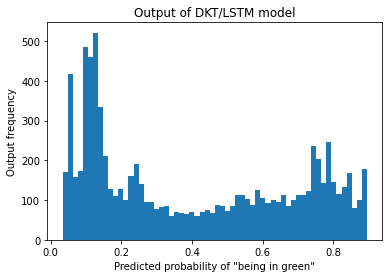

In [29]:
# Distribution of prediction probabilities
ROI_array, green_array, ROI_green_array = preprocess(ROI_df, green_df, ROI_num)
result = dkt_model.predict([ROI_green_array[:, 0:-1], ROI_array[:, 1:]])
result = result[:,:,0].tolist()
result = sum(result, []) # merge lists
plt.hist(result,bins=60)
plt.ylabel('Output frequency')
plt.xlabel('Predicted probability of "being in green"')
plt.title('Output of DKT/LSTM model')
plt.show() 

613.0

### BKT: Building a BKT model (where skills = ROIs and correct = in green)

In [31]:
# Initialize the model
bkt_model = Model_bkt(seed = 42, num_fits = 1)

In [32]:
# Train model
dfff = dff
dfff['InGreen']=dfff['InGreen'].replace(dict_green)
dfff = dfff.reset_index()
dfff['index'] = range(len(dfff))
dfff = dfff.rename({'id':'user_id'}, axis=1)

defaults = {'order_id': 'index', 'skill_name': 'ROI', 'correct': 'InGreen'}

bkt_model.fit(data = dfff, defaults = defaults)

#### Inspecting BKT parameters

In [33]:
# Inspecting parameters for different ROI
params = bkt_model.params().reset_index()
params[params['skill']=='M2']

,skill,param,class,value
40,M2,prior,default,0.23107
41,M2,learns,default,0.02447
42,M2,guesses,default,0.19302
43,M2,slips,default,0.12461
44,M2,forgets,default,0.00000


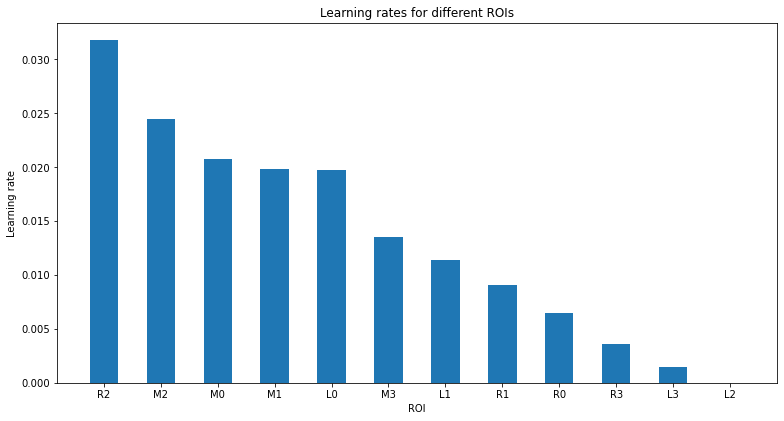

In [34]:
# Visualizing the learning rates for different ROIs
learns = params.loc[params['param'].isin(["learns"])].sort_values(by='value',ascending=False)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(learns['skill'],learns['value'],0.5)
plt.xlabel('ROI')
plt.ylabel('Learning rate')
plt.title('Learning rates for different ROIs')
plt.show()

#### Evaluating accuracy

In [36]:
training_acc = bkt_model.evaluate(data = dfff, metric = 'accuracy')
print('The model accuracy is: ', training_acc)

The model accuracy is:  0.8324802233597022


In [119]:
# 30% of data used as testing data
test_prop = 0.3

# Train model
bkt_model2 = Model_bkt(seed = 42, num_fits = 1)

# Split the data into 50% training and 50% test data
idx_split = np.array(dfff.index.unique())
np.random.seed(42)
np.random.shuffle(idx_split)
training_data = dfff.loc[idx_split[int(test_prop * len(idx_split)):]]
test_data = dfff.loc[idx_split[:int(test_prop * len(idx_split))]]
training_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)

# Fit BKT to training data
bkt_model2.fit(data = training_data, defaults = defaults, skills = list(dict_ROIs.keys()))

# Check accuracy of prediction of test data
test_accuracy = bkt_model2.evaluate(data = test_data, metric = 'accuracy')
test_rmse = bkt_model2.evaluate(data = test_data, metric = 'rmse')

print("Test data accuracy: %f" % test_accuracy)
print("Test data RSME: %f" % test_rmse)

Test data accuracy: 0.807215
Test data RSME: 0.379640


#### Baseline prediction (using average time in green)

In [122]:
train_percent_green = (train_green_df.iloc[:,2:]==1).sum().sum()/(train_green_df.iloc[:,2:].size)
test_percent_green = (test_green_df.iloc[:,2:]==1).sum().sum()/(test_green_df.iloc[:,2:].size)
print('The percentage of instances in green in the training data is: ', train_percent_green)
print('The percentage of instances in green in the testing data is: ', test_percent_green)

# predictions for BKT
preds_bkt = bkt_model2.predict(data = test_data)

# and ensure that it is the same as a call to the evaluate function.
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Caluclating RSME manually, as a sanity check
manual_training_rmse = rmse(preds_bkt['InGreen'],
                            preds_bkt['correct_predictions'])
print('The manually calculated RMSE using BKT is: ', manual_training_rmse)

# Prediction RMSE using average
preds_average = preds_bkt
preds_average['correct_predictions'] = [train_percent_green]*len(preds_average)

# Filter out the data for which we did not train!
avg_training_rmse = rmse(preds_average['InGreen'],
                            preds_average['correct_predictions'])
print('The RMSE using average is : ', avg_training_rmse)



The percentage of instances in green in the training data is:  0.4159869494290375
The percentage of instances in green in the testing data is:  0.41076672104404566
The manual RMSE is using BKT is:  0.37964002434211364
The RMSE using average is :  0.4948435192320976
